# Introduction to pycox

We will here repeat the experiments from 01_quick_start.ipynb, but in a more configurable manner.

**NOTE: These modes are in no way optimal! They are small and poorly tuned, just so they are fast to run on a laptop.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
from pycox.models.cox import CoxPH, CoxTime
# from pycox.models.high_level import CoxPHLinear, CoxTimeReluNet, CoxPHReluNet
import pycox.simulations as sims
import pycox.callbacks.callbacks as cb

# Simulations

We create a simulated dataset withe survival times as function of 3 covariates.

See paper (ref pycox paper) if you want to understand the details.

In [3]:
np.random.seed(123)

In [4]:
h0 = 0.01 # baseline hazard
max_duration = 30. # Censor durateions larger than 30
c0 = 30. # Cencoring distribution
sim = sims.NonLinearNonPH(h0, max_duration, c0)

In [5]:
n_tr = 10000 # Training samples
n_val = 1000 # Validation samples
n_te = 1000 # Testing samples

In [6]:
Xtr, t_tr, e_tr = sim.simulate(n_tr) # [X, times, event indicators]
Xval, t_val, e_val = sim.simulate(n_val) 
Xte, t_te, e_te = sim.simulate(n_te) 

In [7]:
def make_df(X, t, e):
    return (pd.DataFrame(X, columns=['x0', 'x1', 'x2'])
            .assign(time=t, event=e))

In [8]:
train = make_df(Xtr, t_tr, e_tr)
val = make_df(Xval, t_val, e_val)
test = make_df(Xte, t_te, e_te)

In [9]:
train.head()

,x0,x1,x2,time,event
0,0.392938,-0.427721,-0.546297,0.916210,False
1,0.102630,0.438938,-0.153787,23.354235,True
2,0.961528,0.369659,-0.038136,6.506384,True
3,-0.215765,-0.313644,0.458099,17.113842,True
4,-0.122856,-0.880644,-0.203911,19.123400,True


## Features scaling

Covariates needs to be standardized. 
We use the DataFrame mapper from sklearn_pandas, but you are free to scale them however you want.

Here we also scale time (with MapperCoxTime), this is only necessary for the Cox-Time models, and does not affect the Cox models with proportional hazards.

In [10]:
from pycox.utils.utils import MapperCoxTime
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

In [11]:
stdscale_cols = [([col], StandardScaler()) for col in train.columns.drop(['time', 'event'])]
cov_mapper = DataFrameMapper(stdscale_cols)
mapper = MapperCoxTime(cov_mapper, 'time', 'event')

In [12]:
df_train = mapper.fit_transform(train)
df_val = mapper.transform(val)
df_test = mapper.transform(test)

In [13]:
df_train.head()

,x0,x1,x2,time,event
0,0.693886,-0.749048,-0.952026,-1.086793,False
1,0.189430,0.763565,-0.271929,1.430482,True
2,1.681897,0.642651,-0.071542,-0.459643,True
3,-0.363829,-0.549944,0.788279,0.730386,True
4,-0.202384,-1.539551,-0.358779,0.955834,True


# Cox-SGD

Regular proportional Cox regression, with linear $g(x)$ .

$h(t, x) = h_0(t) \exp[g(x)]$

In [14]:
input_size = df_train.drop(['time', 'event'], axis=1).shape[1]

### Linear pytorch model

For simple pytorch models, we can just use nn.Sequential.

In [15]:
import torch
from torch import nn, optim

In [16]:
linear_g = nn.Sequential(nn.Linear(input_size, 1, bias=False))
optimizer = optim.Adam(linear_g.parameters(), lr=0.001)

In [17]:
cox_sgd = CoxPH(linear_g, optimizer, device='cpu')

In [18]:
%%time
log = cox_sgd.fit(df_train, 'time', 'event', epochs=100, verbose=False)

CPU times: user 7.98 s, sys: 299 ms, total: 8.28 s
Wall time: 8.92 s


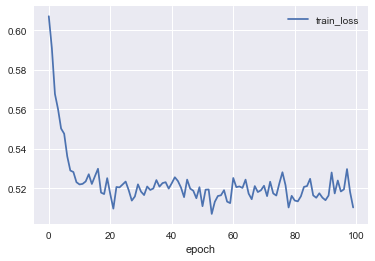

In [19]:
_ = log.to_pandas().plot()

In [20]:
cox_sgd.concordance_index(df_test) # A common evaluation measures for proportional models.

0.8078713285829396

# Cox-MLP

Regular proportional Cox regression, but where $g(x)$ is an MLP.

$h(t, x) = h_0(t) \exp[g(x)]$

We let the MLP have ReLU acitaatoins, 2 hidden layers, with 32 nodes in each layer, and batch norm between layers.

In [21]:
def relu_block(n_input, n_output):
    net = nn.Sequential(nn.Linear(n_input, n_output),
                        nn.ReLU(), 
                        nn.BatchNorm1d(n_output))
    return net

class ReluNet(nn.Module):
    '''Simple ReLU net.

    Parameters:
        input_size: Input size.
        n_layers: Number of layers.
        n_nodes: Size of each layer.
    '''
    def __init__(self, input_size, n_layers, n_nodes):
        super().__init__()
        self.input_size = input_size
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        
        self.first_module = relu_block(self.input_size, self.n_nodes)
        mid_modules = [relu_block(self.n_nodes, self.n_nodes)
                       for i in range(self.n_layers - 1)]
        self.mid_modules = nn.Sequential(*mid_modules)
        self.out_module = nn.Sequential(nn.Linear(self.n_nodes, 1, bias=False))

    def forward(self, x):
        out = self.first_module(x)
        out = self.mid_modules(out)
        out = self.out_module(out)
        return out

In [22]:
mlp_g = ReluNet(input_size, n_layers=2, n_nodes=32)

In [23]:
mlp_g

ReluNet(
  (first_module): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mid_modules): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (out_module): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=False)
  )
)

#### We can now specify the CoxPH model

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [25]:
optimizer = optim.Adam(mlp_g.parameters())
cox_mlp = CoxPH(mlp_g, optimizer, device)

## Callbacks

To monitor the training, we can use callbacks. This might be simpler than altering the trainig loop.

We add:

-  Monitor validation loss.
-  Early stopping based on validation loss (this also saves the models).
-  Decrease learning rate on val_loss plateau.

In [26]:
# n_reps repeats the sampling in the likelihood, making the measure more stable.
val_loss = cb.MonitorCoxLoss(df_val, n_reps=5)
es = cb.EarlyStopping(val_loss, patience=20, model_file_path='cox_mlp.torch')

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=10, verbose=True,
                                                 threshold=1e-3, min_lr=1e-6)
lr_sched = cb.LRScheduler(scheduler, val_loss)
callbacks = [val_loss, es, lr_sched]

In [27]:
%%time
log = cox_mlp.fit(df_train, 'time', 'event', batch_size=128, epochs=500, verbose=False,
                  callbacks=callbacks)

Epoch    24: reducing learning rate of group 0 to 2.0000e-04.
CPU times: user 13.5 s, sys: 853 ms, total: 14.3 s
Wall time: 7.14 s


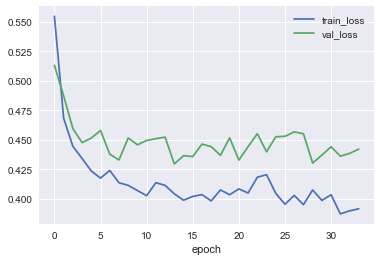

In [28]:
_ = (log.to_pandas()
     .join(val_loss.to_pandas().rename(columns={'loss': 'val_loss'}))
     .plot())

In [29]:
cox_mlp.concordance_index(df_test)

0.8422605975384324

#### Load best model
To retreive the model, we need to recalculate the baseline.

In [30]:
cox_mlp.load_model_weights('cox_mlp.torch')
_ = cox_mlp.compute_baseline_hazards()

/Users/havard/packages/pycox/pycox/models/cox.py:282: UserWarning: Might need to transfer to cuda???
  warnings.warn('Might need to transfer to cuda???')
/Users/havard/packages/pycox/pycox/models/cox.py:283: UserWarning: Need to recompute baseline hazards after loading.
  warnings.warn('Need to recompute baseline hazards after loading.')
/Users/havard/packages/pycox/pycox/models/cox.py:284: UserWarning: Might need to set optim again!
  warnings.warn('Might need to set optim again!')


In [31]:
cox_mlp.concordance_index(df_test)

0.8386172246535952

### Plot survival curves


In [32]:
sub = df_test.sample(6)

In [33]:
surv_preds = cox_mlp.predict_survival_function(sub)

If we have scaled the time (which is only necessary for the CoxTime models), we can compute the inverse scaling.

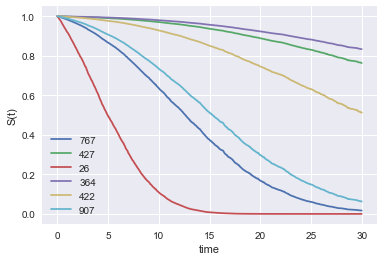

In [34]:
orig_scale = mapper.inverse_duration(surv_preds.index)
surv_preds = surv_preds.set_index(orig_scale)
surv_preds.plot()
plt.ylabel('S(t)')
_ = plt.xlabel('time')

## Sidenote: Printing training progress

To print the trainig progress, we can specify what to print in the verbose argument.

In [35]:
cox_mlp_2 = CoxPH(ReluNet(input_size, n_layers=2, n_nodes=32), device='cpu')
val_loss_2 = cb.MonitorCoxLoss(df_val, n_reps=5)

In [36]:
%%time
log = cox_mlp_2.fit(df_train, 'time', 'event', batch_size=128, epochs=5, callbacks=[val_loss_2], 
                    verbose=True)

Epoch: 0,	time: 0 sec,	train_loss: 0.5344
Epoch: 1,	time: 0 sec,	train_loss: 0.4498
Epoch: 2,	time: 0 sec,	train_loss: 0.4373
Epoch: 3,	time: 0 sec,	train_loss: 0.4246
Epoch: 4,	time: 0 sec,	train_loss: 0.4164
CPU times: user 1.98 s, sys: 92.6 ms, total: 2.08 s
Wall time: 947 ms


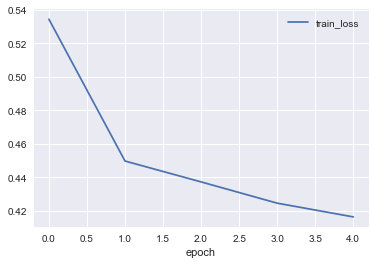

In [37]:
_ = log.to_pandas().plot()

In [38]:
%%time
log = cox_mlp_2.fit(df_train, 'time', 'event', batch_size=128, epochs=5, callbacks=[val_loss_2], 
                    verbose={'val_loss': val_loss_2})

Epoch: 5,	time: 0 sec,	train_loss: 0.4079,	val_loss: 0.4660
Epoch: 6,	time: 0 sec,	train_loss: 0.4094,	val_loss: 0.4502
Epoch: 7,	time: 0 sec,	train_loss: 0.4111,	val_loss: 0.4594
Epoch: 8,	time: 0 sec,	train_loss: 0.4259,	val_loss: 0.4454
Epoch: 9,	time: 0 sec,	train_loss: 0.4223,	val_loss: 0.4505
CPU times: user 1.89 s, sys: 94.1 ms, total: 1.99 s
Wall time: 793 ms


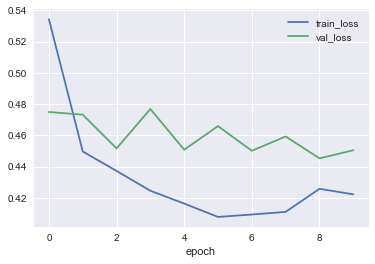

In [39]:
_ = log.to_pandas().plot()

# Cox-Time

We repeat everyting with the Cox-Time model.

This model has no longer proportional hazards, but a time dependent $g(x, t)$.

$h(t, x) = h_0(t) \exp[g(x, t)]$

We need larger inputsize size time is noe a covariate.

In [40]:
input_size_time = input_size + 1
mlp_g = ReluNet(input_size_time, n_layers=2, n_nodes=32)
optimizer = optim.Adam(mlp_g.parameters())
cox_time = CoxTime(mlp_g, optimizer, device)

In [41]:
# NOTE!!!!
#    We use a different callback for val_loss in CoxTime!!!!!!!!!!
val_loss_time = cb.MonitorCoxTimeLoss(df_val, n_reps=5)
es = cb.EarlyStopping(val_loss_time, patience=20, model_file_path='cox_time.torch')

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=10, verbose=True,
                                                 threshold=1e-3, min_lr=1e-6)
lr_sched = cb.LRScheduler(scheduler, val_loss_time)
callbacks = [val_loss_time, es, lr_sched]

In [42]:
%%time
log = cox_time.fit(df_train, 'time', 'event', batch_size=128, epochs=500, verbose=False,
                  callbacks=callbacks)

Epoch    34: reducing learning rate of group 0 to 2.0000e-04.
Epoch    51: reducing learning rate of group 0 to 4.0000e-05.
Epoch    70: reducing learning rate of group 0 to 8.0000e-06.
CPU times: user 40.9 s, sys: 1.7 s, total: 42.6 s
Wall time: 18 s


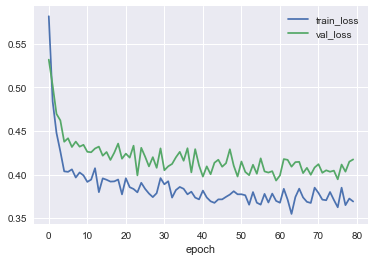

In [43]:
_ = (log.to_pandas()
     .join(val_loss_time.to_pandas().rename(columns={'loss': 'val_loss'}))
     .plot())

### Comparing val_loss with Cox-MLP

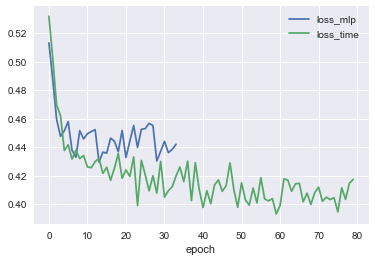

In [44]:
(val_loss.to_pandas()
 .join(val_loss_time.to_pandas(), how='outer', lsuffix='_mlp', rsuffix='_time')
 .plot())
None

#### Load best model

When calculating the baseline, we suggest that we only use a sample of the trainingset. If not, it will be very computational.

In [45]:
%%time
cox_time.load_model_weights('cox_time.torch')
_ = cox_time.compute_baseline_hazards(sample=3000)

/Users/havard/packages/pycox/pycox/models/cox.py:282: UserWarning: Might need to transfer to cuda???
  warnings.warn('Might need to transfer to cuda???')
/Users/havard/packages/pycox/pycox/models/cox.py:283: UserWarning: Need to recompute baseline hazards after loading.
  warnings.warn('Need to recompute baseline hazards after loading.')
/Users/havard/packages/pycox/pycox/models/cox.py:284: UserWarning: Might need to set optim again!
  warnings.warn('Might need to set optim again!')


CPU times: user 16.3 s, sys: 412 ms, total: 16.7 s
Wall time: 10.7 s


### Plot survival curves

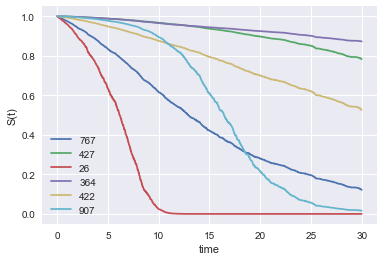

In [46]:
surv_preds_time = cox_time.predict_survival_function(sub)
orig_scale = mapper.inverse_duration(surv_preds_time.index)
surv_preds_time = surv_preds_time.set_index(orig_scale)
surv_preds_time.plot()
plt.ylabel('S(t)')
_ = plt.xlabel('time')

# Get binary predictions

We now create a binary dataset at time 15.
Hence, we label events prior to 15 as True, and events after 15 as False.

We also need to remove individuals censored before time 15.

In [47]:
time = 15.
t_time = mapper.transform_duration(time).values[0] # Transformed time

#### Create a dataset with labels, and censored individuals are removed

In [48]:
df_test_15 = (df_test
              .assign(label=lambda x: x['time'] < t_time)
              .assign(cencored=lambda x: x['label'] & (x['event'] == False))
              .loc[lambda x: x['cencored']==False]
              .drop('cencored', axis=1)
             )

In [49]:
df_test_15.head()

,x0,x1,x2,time,event,label
0,-1.618569,1.592340,0.243331,-0.348070,True,True
1,0.787524,-0.926247,-1.648152,0.758731,True,False
2,0.968812,-0.941664,0.329002,-0.014225,True,True
4,1.726448,-1.479365,1.072847,-0.609938,True,True
5,1.127898,-0.662604,1.015563,0.187790,True,True


#### Get predictions

In [50]:
%%time
surv_15 = cox_time.predict_survival_at_times(t_time, df_test_15)

CPU times: user 10.7 s, sys: 270 ms, total: 11 s
Wall time: 6.61 s


In [51]:
preds = 1 - surv_15.values.flatten()
true = df_test_15['label'].values

#### Get accuracy and ROC AUC

In [52]:
from sklearn import metrics

In [53]:
metrics.accuracy_score(true, preds > 0.5)

0.8724559023066486

In [54]:
metrics.roc_auc_score(true, preds)

0.9390985540756693

### ... and for Cox-MLP

In [55]:
%%time
surv_15 = cox_mlp.predict_survival_at_times(t_time, df_test_15)

CPU times: user 9.95 ms, sys: 3.18 ms, total: 13.1 ms
Wall time: 6.77 ms


In [56]:
preds = 1 - surv_15.values.flatten()

In [57]:
metrics.accuracy_score(true, preds > 0.5)

0.8656716417910447

In [58]:
metrics.roc_auc_score(true, preds)

0.9363983339404209

### ... and for Cox-SGD

In [59]:
%%time
surv_15 = cox_sgd.predict_survival_at_times(t_time, df_test_15)

CPU times: user 4.58 ms, sys: 1.35 ms, total: 5.93 ms
Wall time: 5.25 ms


In [60]:
preds = 1 - surv_15.values.flatten()

In [61]:
metrics.accuracy_score(true, preds > 0.5)

0.8018995929443691

In [62]:
metrics.roc_auc_score(true, preds)

0.8794086438718465